# **Reinforcement Learning and Dynamic Optimization.**

**Technical University of Crete**

Assignment 2 (2024) - Day Trading in the Stock Market

Student: Karalis Asterinos

AM: 2020030107

# **Brief code description**

#### Data Loading
- The stock price data is loaded from a CSV file and formatted with column names `Stock 0` to `Stock 9`.

#### Multiplicative Weights without Fees
- A method `multiplicative_weights` is defined to update weights for each stock based on daily returns and calculates cumulative profit and regret over time.

#### Multiplicative Weights with Fees
- A method `multiplicative_weights_with_fees` is defined to account for transaction fees, updating weights and calculating cumulative profit and regret considering the fees.

#### UCB Bandit Algorithm for Stock Trading
- A `StockArm` class simulates stock returns.
- The `UCBStockTrading` class implements the Upper Confidence Bound (UCB) algorithm.
- The `simulate_ucb` function uses the UCB algorithm to select stocks and update rewards considering transaction fees.


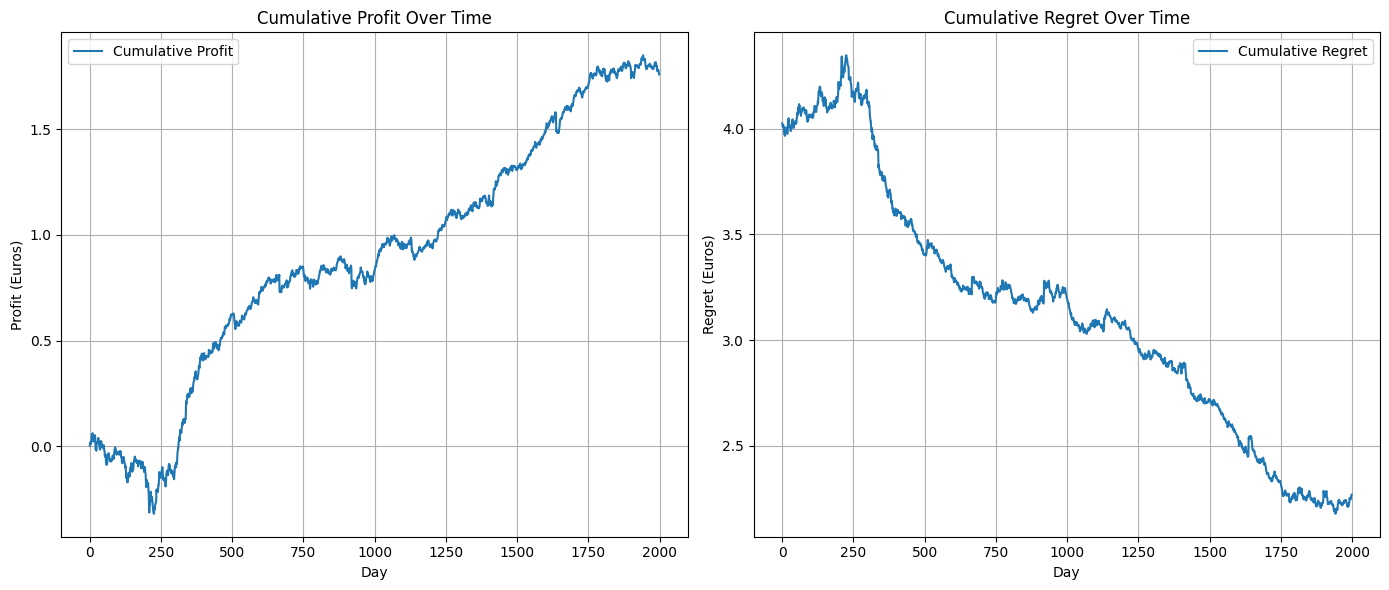

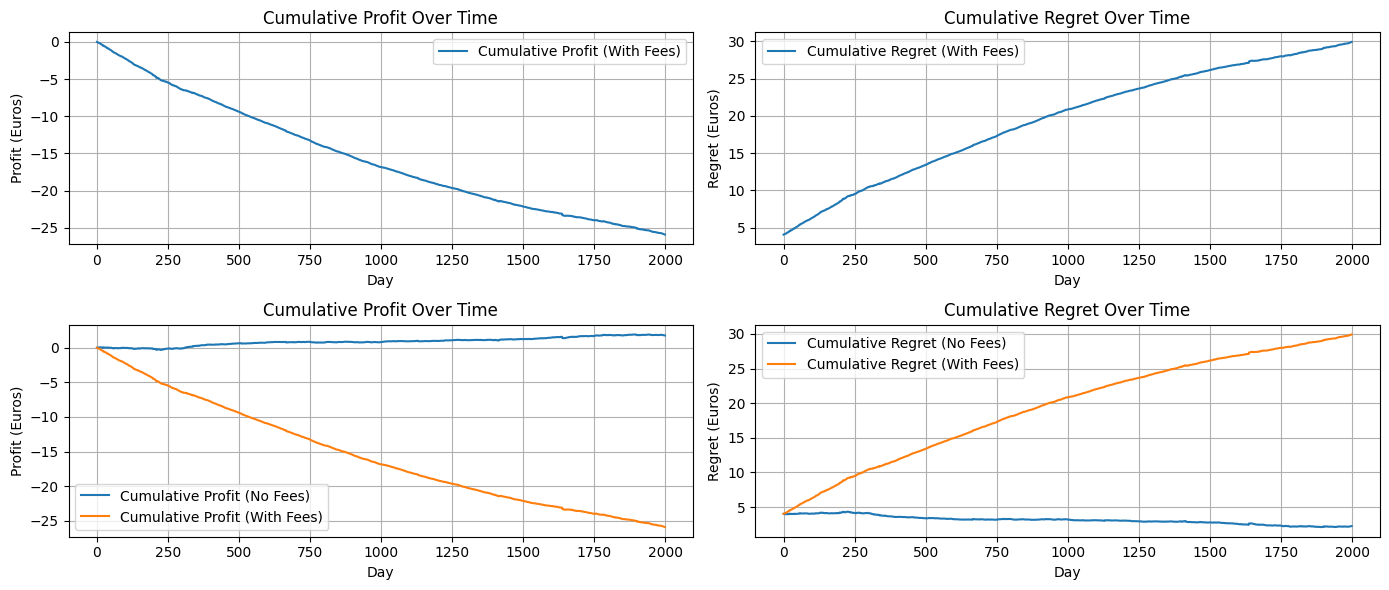

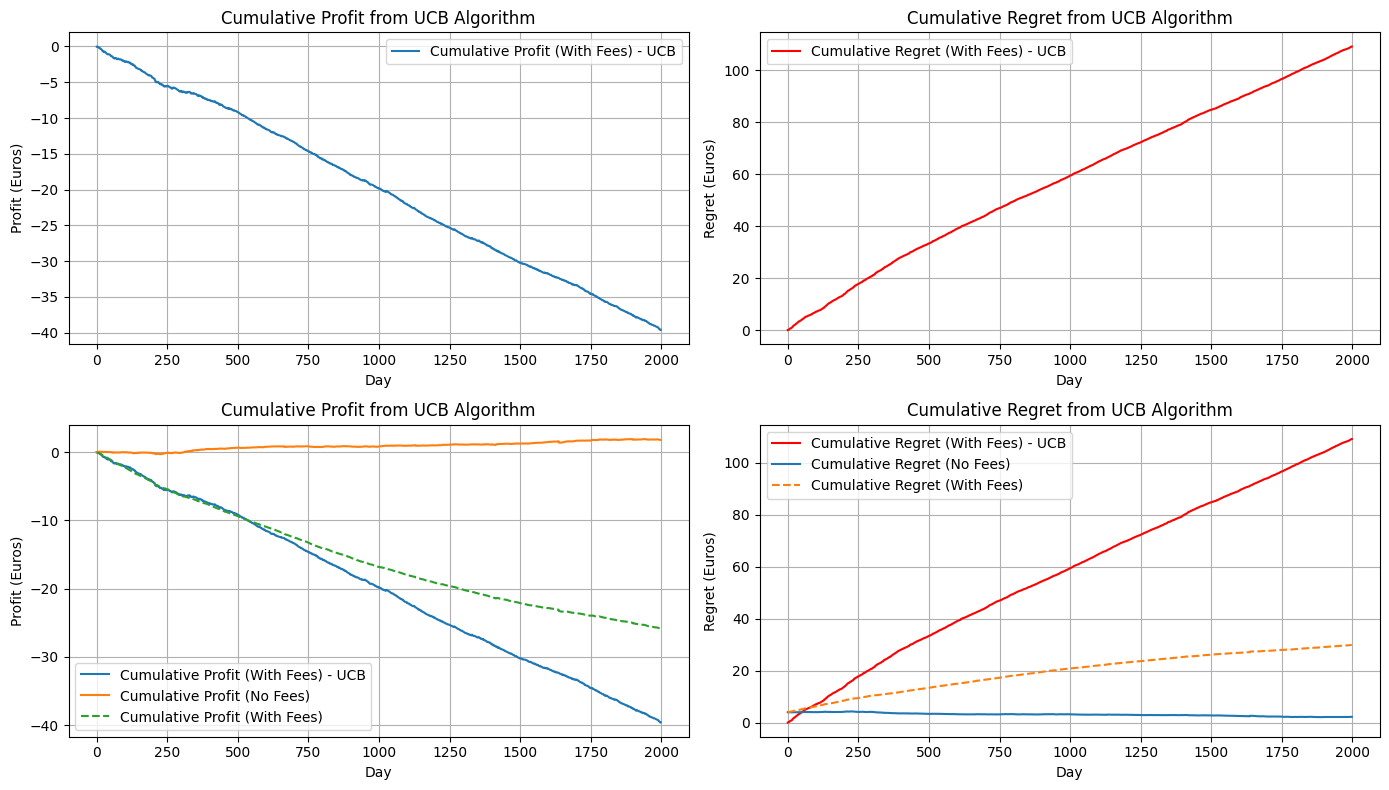

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the data from the CSV file to see the first few rows
file_path = 'stocks.csv'
stocks_data = pd.read_csv(file_path, header=None)
stocks_data.columns = [f"Stock {i}" for i in range(10)]  # Naming columns as Stock 0, Stock 1, ..., Stock 9
stocks_data.head()

# Task1: Method for multiplicative weights without fees
def multiplicative_weights(data, learning_rate=0.05):
    # Initialize parameters and lists to store results
    num_stocks = data.shape[1]
    weights = np.ones(num_stocks)
    cumulative_profit = []
    cumulative_regret = []
    total_profit = 0
    best_stock_profit = np.max(np.cumsum(data.values, axis=0)[-1])

    # Iterate through each day's stock data
    for day in range(data.shape[0]):
        normalized_weights = weights / np.sum(weights)
        daily_returns = np.dot(normalized_weights, data.iloc[day])
        total_profit += daily_returns
        cumulative_profit.append(total_profit)

        # Calculate regret as the difference between the best possible stock profit and actual profit
        regret = best_stock_profit - total_profit
        cumulative_regret.append(regret)

         # Update weights based on the day's returns
        weights *= np.exp(learning_rate * data.iloc[day])

    return cumulative_profit, cumulative_regret

# Load the stock data from CSV
data = pd.read_csv(file_path, header=None)
data.columns = [f"Stock {i}" for i in range(10)]

# Apply the Multiplicative Weights algorithm
cumulative_profit, cumulative_regret = multiplicative_weights(data)

# Plotting the results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(cumulative_profit, label='Cumulative Profit')
plt.grid(True)
plt.title('Cumulative Profit Over Time')
plt.xlabel('Day')
plt.ylabel('Profit (Euros)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.grid(True)
plt.title('Cumulative Regret Over Time')
plt.xlabel('Day')
plt.ylabel('Regret (Euros)')
plt.legend()

plt.tight_layout()
plt.show()

# Task2: Method for multiplicative weights with fees
def multiplicative_weights_with_fees(data, fees, learning_rate=0.05):
    num_stocks = data.shape[1]
    weights = np.ones(num_stocks)
    cumulative_profit_no_fees = []
    cumulative_profit_fees = []
    cumulative_regret_no_fees = []
    cumulative_regret_fees = []
    total_profit_no_fees = 0
    total_profit_fees = 0
    best_stock_profit = np.max(np.cumsum(data, axis=0).iloc[-1])

    for day in range(data.shape[0]):
        # Normalize weights to form a probability distribution
        normalized_weights = weights / np.sum(weights)

        # Calculate daily returns using the weighted sum of stock returns
        daily_returns = np.dot(normalized_weights, data.iloc[day])
        daily_returns_fees = np.dot(normalized_weights, data.iloc[day] - fees)  # Subtracting fixed fees from returns

        # Update total profits for both scenarios (with and without fees)
        total_profit_no_fees += daily_returns
        total_profit_fees += daily_returns_fees

        cumulative_profit_no_fees.append(total_profit_no_fees)
        cumulative_profit_fees.append(total_profit_fees)

        # Calculate regrets for both scenarios
        regret_no_fees = best_stock_profit - total_profit_no_fees
        regret_fees = best_stock_profit - total_profit_fees

        cumulative_regret_no_fees.append(regret_no_fees)
        cumulative_regret_fees.append(regret_fees)

        # Update weights using the multiplicative weights update rule
        # Using returns adjusted for fees for updating weights
        weights *= np.exp(learning_rate * (data.iloc[day] - fees))

    return cumulative_profit_no_fees, cumulative_profit_fees, cumulative_regret_no_fees, cumulative_regret_fees

# Define transaction fees for each stock
transaction_fees = np.array([0.005 * i for i in range(10)])

# Apply the Multiplicative Weights algorithm with transaction fees
cumulative_profit_no_fees, cumulative_profit_fees, cumulative_regret_no_fees, cumulative_regret_fees = multiplicative_weights_with_fees(stocks_data, transaction_fees)

# Plotting the result

# Profit with fess - Alone
plt.figure(figsize=(14, 6))
plt.subplot(2,2,1)
plt.plot(cumulative_profit_fees, label='Cumulative Profit (With Fees)')
plt.grid(True)
plt.title('Cumulative Profit Over Time')
plt.xlabel('Day')
plt.ylabel('Profit (Euros)')
plt.legend()

# Regret with fess - Alone
plt.subplot(2,2,2)
plt.plot(cumulative_regret_fees, label='Cumulative Regret (With Fees)')
plt.grid(True)
plt.title('Cumulative Regret Over Time')
plt.xlabel('Day')
plt.ylabel('Regret (Euros)')
plt.legend()

# Combined printing of profit
plt.subplot(2, 2, 3)
plt.plot(cumulative_profit_no_fees, label='Cumulative Profit (No Fees)')
plt.plot(cumulative_profit_fees, label='Cumulative Profit (With Fees)')
plt.grid(True)
plt.title('Cumulative Profit Over Time')
plt.xlabel('Day')
plt.ylabel('Profit (Euros)')
plt.legend()

# Combined printing of regret
plt.subplot(2, 2, 4)
plt.plot(cumulative_regret_no_fees, label='Cumulative Regret (No Fees)')
plt.plot(cumulative_regret_fees, label='Cumulative Regret (With Fees)')
plt.grid(True)
plt.title('Cumulative Regret Over Time')
plt.xlabel('Day')
plt.ylabel('Regret (Euros)')
plt.legend()

plt.tight_layout()
plt.show()

# Task3: Using UCB bandits algorithm from the previous assignment.
# Modified Arm class to simulate stock returns
class StockArm():
    def __init__(self, returns):
        # Initialize with stock returns data
        self.returns = returns

    def draw(self, day):
        # Simulate obtaining the return for a given day
        return self.returns[day]

class UCBStockTrading():
    def __init__(self):
        # Initialize lists to keep track of how often each arm is used and their estimated values
        self.counts = []
        self.values = []

    def initialize(self, n_arms):
        # Start with zero counts and zero values for each stock arm
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms

    def select_arm(self):
        # Select an arm based on UCB values
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = [0.0] * n_arms
        total_counts = sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus
        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        # Update the selected arm's count and value based on the reward received
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / float(n)) * self.values[chosen_arm] + (1 / float(n)) * reward

def simulate_ucb(stock_data, transaction_fees):
    # Simulate the UCB algorithm for stock trading
    # The algorithm is a modification from the 1st assignment
    num_days = stock_data.shape[0]
    num_stocks = stock_data.shape[1]
    arms = [StockArm(stock_data.iloc[:, i]) for i in range(num_stocks)]
    algo = UCBStockTrading()
    algo.initialize(num_stocks)
    cumulative_rewards = np.zeros(num_days)
    cumulative_regrets = np.zeros(num_days)
    optimal_rewards = stock_data.max(axis=1)  # Maximum return each day without subtracting fees here

    cumulative_optimal = 0
    for day in range(num_days):
        chosen_arm = algo.select_arm()
        reward = arms[chosen_arm].draw(day) - transaction_fees[chosen_arm]
        algo.update(chosen_arm, reward)
        cumulative_rewards[day] = cumulative_rewards[day - 1] + reward if day > 0 else reward
        cumulative_optimal += optimal_rewards[day]
        cumulative_regrets[day] = cumulative_optimal - cumulative_rewards[day]

    return cumulative_rewards, cumulative_regrets

# Define transaction fees for each stock
transaction_fees = np.array([0.005 * i for i in range(10)])

# Assuming stocks_data is already loaded and formatted
cumulative_rewards, cumulative_regrets = simulate_ucb(stocks_data, transaction_fees)

# Plotting
plt.figure(figsize=(14, 8))

# Plotting profit with fees using UCB - Alone
plt.subplot(2, 2, 1)
plt.plot(cumulative_rewards, label='Cumulative Profit (With Fees) - UCB')
plt.grid(True)
plt.title('Cumulative Profit from UCB Algorithm')
plt.xlabel('Day')
plt.ylabel('Profit (Euros)')
plt.legend()

# Plotting regret with fees using UCB - Alone
plt.subplot(2, 2, 2)
plt.plot(cumulative_regrets, label='Cumulative Regret (With Fees) - UCB', color='red')
plt.grid(True)
plt.title('Cumulative Regret from UCB Algorithm')
plt.xlabel('Day')
plt.ylabel('Regret (Euros)')
plt.legend()

# Combined printing of profit
plt.subplot(2, 2, 3)
plt.plot(cumulative_rewards, label='Cumulative Profit (With Fees) - UCB')
plt.plot(cumulative_profit_no_fees, label='Cumulative Profit (No Fees)')
plt.plot(cumulative_profit_fees, label='Cumulative Profit (With Fees)', linestyle='--')
plt.grid(True)
plt.title('Cumulative Profit from UCB Algorithm')
plt.xlabel('Day')
plt.ylabel('Profit (Euros)')
plt.legend()

# Combined printing of regret
plt.subplot(2, 2, 4)
plt.plot(cumulative_regrets, label='Cumulative Regret (With Fees) - UCB', color='red')
plt.plot(cumulative_regret_no_fees, label='Cumulative Regret (No Fees)')
plt.plot(cumulative_regret_fees, label='Cumulative Regret (With Fees)', linestyle='--')
plt.grid(True)
plt.title('Cumulative Regret from UCB Algorithm')
plt.xlabel('Day')
plt.ylabel('Regret (Euros)')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion
Upon analyzing the results from the three tasks (experts setup without fees, experts setup with fees, and bandits-ucb setup), we observe significant differences in performance across the different algorithms and scenarios:

#### Task 1: Experts Setup without Fees
- **Positive Profit**: The cumulative profit consistently increases over time, indicating effective stock selection and weight adjustment.
- **Decreasing Regret**: The cumulative regret decreases over time, showing that the algorithm performs well compared to the best possible stock, achieving sublinear regret. This suggests that the multiplicative weights method is effective in this ideal scenario.

#### Task 2: Experts Setup with Fees
- **Negative Profit**: The cumulative profit turns negative, primarily due to the additional costs incurred from transaction fees. This highlights the sensitivity of the multiplicative weights method to transaction costs, which can significantly erode profits.
- **Increasing Regret**: The cumulative regret increases, indicating that the performance gap between the algorithm and the best possible stock widens. The transaction fees hinder the algorithm's ability to make profitable adjustments, resulting in higher regret.

#### Task 3: Bandits-UCB Setup
- **Worst Profit**: The cumulative profit is the worst among the three scenarios, reflecting the challenges faced by the UCB algorithm in this context. The UCB algorithm's exploration-exploitation trade-off struggles to cope with the noisy data and delayed feedback, leading to poor stock selection.
- **Highest Regret**: The cumulative regret is the highest, indicating the algorithm's significant underperformance compared to the best possible stock. The UCB algorithm, which only observes rewards at the end of each day, is less effective in navigating the stock market's volatility and noise, resulting in suboptimal decisions.
